# AWN3 (Arabic WordNet V3) Quality Assessment

This notebook provides a comprehensive quality assessment of the AWN3 Arabic WordNet.

**Assessment Areas:**
1. Basic Statistics
2. Coverage Analysis
3. Structural Quality (Taxonomy)
4. Relation Quality
5. Definition & Example Quality
6. ILI Alignment
7. Comparison with OMW-ARB
8. Summary Report

## Setup

In [1]:
import wn
from collections import defaultdict, Counter
import statistics
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set up matplotlib for Arabic text
plt.rcParams['font.family'] = ['Arial', 'DejaVu Sans']
plt.rcParams['figure.figsize'] = [12, 6]

print("wn version:", wn.__version__)

wn version: 0.14.0


In [2]:
# Load wordnets
print("Loading wordnets...")

awn3 = wn.Wordnet('awn3')
oewn = wn.Wordnet('oewn:2024')

# Try to load OMW-ARB for comparison
try:
    omw_arb = wn.Wordnet('omw-arb:1.4')
    HAS_OMW_ARB = True
    print("✓ OMW-ARB loaded")
except:
    HAS_OMW_ARB = False
    print("⚠ OMW-ARB not available")

print("✓ AWN3 loaded")
print("✓ OEWN loaded")

Loading wordnets...
✓ OMW-ARB loaded
✓ AWN3 loaded
✓ OEWN loaded


In [3]:
# Cache synsets for performance
print("Caching synsets...")
awn3_synsets = list(awn3.synsets())
awn3_words = list(awn3.words())
awn3_senses = list(awn3.senses())
oewn_synsets = list(oewn.synsets())

if HAS_OMW_ARB:
    omw_synsets = list(omw_arb.synsets())
    omw_words = list(omw_arb.words())
    omw_senses = list(omw_arb.senses())

print(f"AWN3: {len(awn3_synsets):,} synsets, {len(awn3_words):,} words, {len(awn3_senses):,} senses")
print(f"OEWN: {len(oewn_synsets):,} synsets")

Caching synsets...
AWN3: 9,567 synsets, 12,310 words, 12,310 senses
OEWN: 120,630 synsets


---
## Section 1: Basic Statistics

In [4]:
print("=" * 70)
print("SECTION 1: BASIC STATISTICS")
print("=" * 70)

print(f"\n{'Metric':<35} {'AWN3':>15}")
print("-" * 50)
print(f"{'Total Synsets':<35} {len(awn3_synsets):>15,}")
print(f"{'Total Words (unique lemmas)':<35} {len(awn3_words):>15,}")
print(f"{'Total Senses':<35} {len(awn3_senses):>15,}")

SECTION 1: BASIC STATISTICS

Metric                                         AWN3
--------------------------------------------------
Total Synsets                                 9,567
Total Words (unique lemmas)                  12,310
Total Senses                                 12,310


In [5]:
# POS breakdown
pos_names = {'n': 'Nouns', 'v': 'Verbs', 'a': 'Adjectives', 'r': 'Adverbs', 's': 'Adj Satellites'}

synset_pos_counts = Counter(ss.pos for ss in awn3_synsets)
word_pos_counts = Counter(w.pos for w in awn3_words)

print("\nPOS Distribution (Synsets):")
print("-" * 50)
for pos, count in sorted(synset_pos_counts.items(), key=lambda x: -x[1]):
    pct = count / len(awn3_synsets) * 100
    print(f"  {pos_names.get(pos, pos):<30} {count:>10,} ({pct:>5.1f}%)")

print("\nPOS Distribution (Words):")
print("-" * 50)
for pos, count in sorted(word_pos_counts.items(), key=lambda x: -x[1]):
    pct = count / len(awn3_words) * 100
    print(f"  {pos_names.get(pos, pos):<30} {count:>10,} ({pct:>5.1f}%)")


POS Distribution (Synsets):
--------------------------------------------------
  Nouns                               6,511 ( 68.1%)
  Verbs                               2,503 ( 26.2%)
  Adjectives                            446 (  4.7%)
  Adverbs                               107 (  1.1%)

POS Distribution (Words):
--------------------------------------------------
  Nouns                               8,120 ( 66.0%)
  Verbs                               3,515 ( 28.6%)
  Adjectives                            561 (  4.6%)
  Adverbs                               114 (  0.9%)


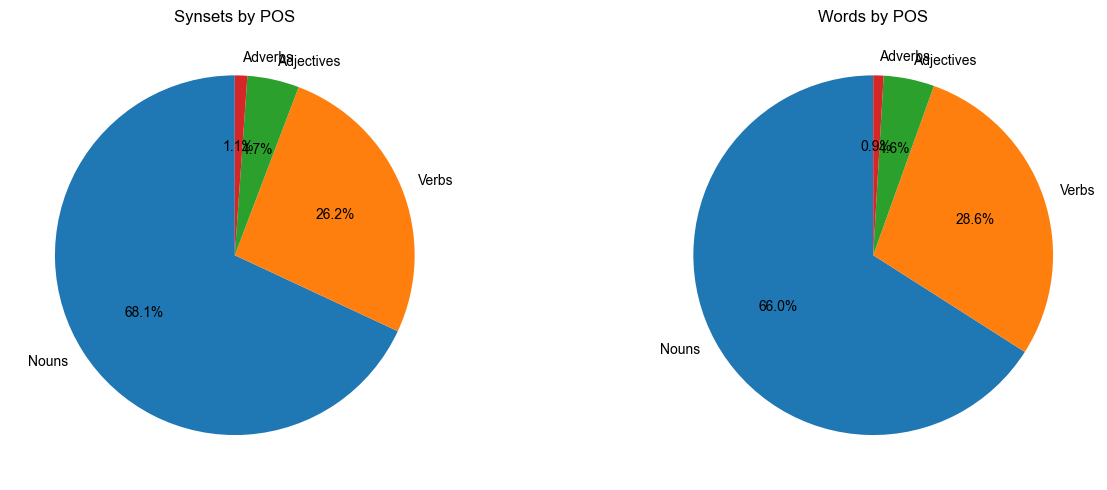

In [6]:
# Visualize POS distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Synset POS
labels = [pos_names.get(pos, pos) for pos in synset_pos_counts.keys()]
sizes = list(synset_pos_counts.values())
axes[0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Synsets by POS')

# Word POS
labels = [pos_names.get(pos, pos) for pos in word_pos_counts.keys()]
sizes = list(word_pos_counts.values())
axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Words by POS')

plt.tight_layout()
plt.show()

In [7]:
# Lexical metrics
print("\nLexical Metrics:")
print("-" * 50)

avg_words_per_synset = len(awn3_senses) / len(awn3_synsets) if awn3_synsets else 0
print(f"{'Avg words per synset':<35} {avg_words_per_synset:>15.2f}")

# Polysemy
word_sense_counts = [len(w.senses()) for w in awn3_words]
avg_senses_per_word = statistics.mean(word_sense_counts) if word_sense_counts else 0
max_polysemy = max(word_sense_counts) if word_sense_counts else 0
polysemous = sum(1 for c in word_sense_counts if c > 1)

print(f"{'Avg senses per word (polysemy)':<35} {avg_senses_per_word:>15.2f}")
print(f"{'Max polysemy':<35} {max_polysemy:>15}")
print(f"{'Polysemous words (>1 sense)':<35} {polysemous:>15,} ({polysemous/len(awn3_words)*100:.1f}%)")


Lexical Metrics:
--------------------------------------------------
Avg words per synset                           1.29
Avg senses per word (polysemy)                 1.00
Max polysemy                                      1
Polysemous words (>1 sense)                       0 (0.0%)


In [8]:
# Most polysemous words
print("\nTop 10 Most Polysemous Words:")
print("-" * 50)
word_polysemy = [(w.lemma(), len(w.senses())) for w in awn3_words]
word_polysemy.sort(key=lambda x: -x[1])
for lemma, count in word_polysemy[:10]:
    print(f"  {lemma:<30} {count:>5} senses")


Top 10 Most Polysemous Words:
--------------------------------------------------
  كيان                               1 senses
  اِسْم                              1 senses
  وَصْف شَفَهِيّ                     1 senses
  وَصْف لَفْظِيّ                     1 senses
  مِثَال                             1 senses
  جِزْء                              1 senses
  قِسْم                              1 senses
  مكوِّن                             1 senses
  فِعْل                              1 senses
  صِفَة                              1 senses


---
## Section 2: Coverage Analysis

In [9]:
print("=" * 70)
print("SECTION 2: COVERAGE ANALYSIS")
print("=" * 70)

print(f"\nCoverage vs English WordNet (OEWN 2024):")
print("-" * 60)
print(f"{'OEWN synsets':<40} {len(oewn_synsets):>15,}")
print(f"{'AWN3 synsets':<40} {len(awn3_synsets):>15,}")
print(f"{'AWN3 coverage of OEWN':<40} {len(awn3_synsets)/len(oewn_synsets)*100:>14.1f}%")

SECTION 2: COVERAGE ANALYSIS

Coverage vs English WordNet (OEWN 2024):
------------------------------------------------------------
OEWN synsets                                     120,630
AWN3 synsets                                       9,567
AWN3 coverage of OEWN                               7.9%


In [10]:
# ILI-based coverage
awn3_ilis = {ss.ili.id for ss in awn3_synsets if ss.ili}
oewn_ilis = {ss.ili.id for ss in oewn_synsets if ss.ili}
common_ilis = awn3_ilis & oewn_ilis

print(f"\nILI-based Coverage:")
print("-" * 60)
print(f"{'AWN3 synsets with ILI':<40} {len(awn3_ilis):>15,}")
print(f"{'OEWN synsets with ILI':<40} {len(oewn_ilis):>15,}")
print(f"{'Common ILIs (aligned concepts)':<40} {len(common_ilis):>15,}")
print(f"{'AWN3 ILI coverage of OEWN ILIs':<40} {len(common_ilis)/len(oewn_ilis)*100:>14.1f}%")


ILI-based Coverage:
------------------------------------------------------------
AWN3 synsets with ILI                              9,539
OEWN synsets with ILI                            117,415
Common ILIs (aligned concepts)                     9,539
AWN3 ILI coverage of OEWN ILIs                      8.1%


In [11]:
# Coverage by POS
print(f"\nCoverage by POS:")
print("-" * 60)
print(f"{'POS':<15} {'AWN3':>10} {'OEWN':>12} {'Coverage':>12}")
print("-" * 60)

coverage_data = []
for pos in ['n', 'v', 'a', 'r']:
    awn3_count = sum(1 for ss in awn3_synsets if ss.pos == pos)
    oewn_count = sum(1 for ss in oewn_synsets if ss.pos == pos)
    coverage = awn3_count / oewn_count * 100 if oewn_count else 0
    coverage_data.append((pos_names[pos], awn3_count, oewn_count, coverage))
    print(f"{pos_names[pos]:<15} {awn3_count:>10,} {oewn_count:>12,} {coverage:>11.1f}%")


Coverage by POS:
------------------------------------------------------------
POS                   AWN3         OEWN     Coverage
------------------------------------------------------------
Nouns                6,511       84,956         7.7%
Verbs                2,503       13,830        18.1%
Adjectives             446        7,502         5.9%
Adverbs                107        3,622         3.0%


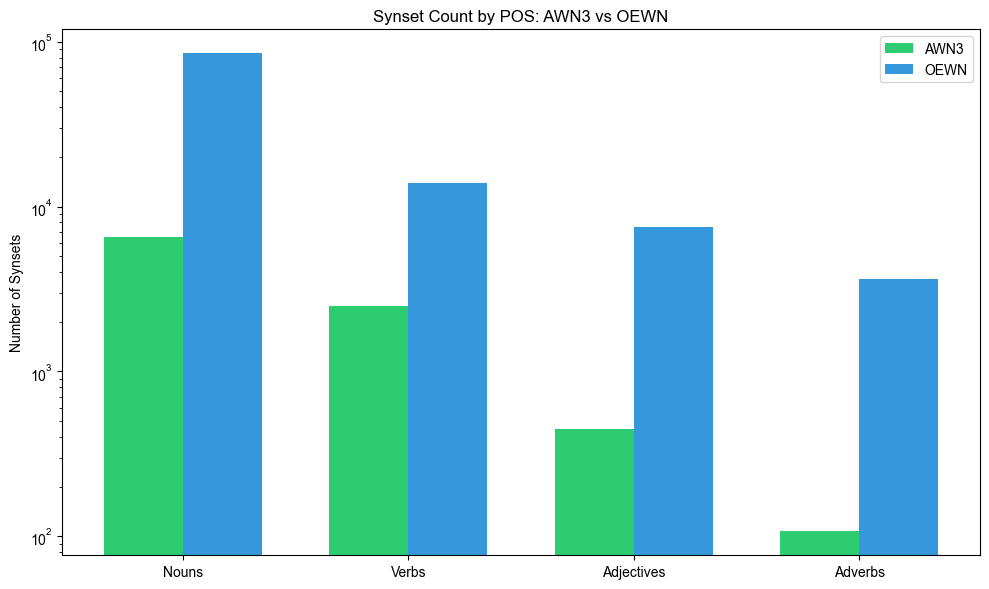

In [12]:
# Visualize coverage by POS
fig, ax = plt.subplots(figsize=(10, 6))

pos_labels = [d[0] for d in coverage_data]
awn3_counts = [d[1] for d in coverage_data]
oewn_counts = [d[2] for d in coverage_data]

x = np.arange(len(pos_labels))
width = 0.35

bars1 = ax.bar(x - width/2, awn3_counts, width, label='AWN3', color='#2ecc71')
bars2 = ax.bar(x + width/2, oewn_counts, width, label='OEWN', color='#3498db')

ax.set_ylabel('Number of Synsets')
ax.set_title('Synset Count by POS: AWN3 vs OEWN')
ax.set_xticks(x)
ax.set_xticklabels(pos_labels)
ax.legend()
ax.set_yscale('log')

plt.tight_layout()
plt.show()

In [13]:
# Synset size distribution
synset_sizes = [len(ss.words()) for ss in awn3_synsets]
size_dist = Counter(synset_sizes)

print(f"\nSynset Size Distribution (words per synset):")
print("-" * 60)
print(f"{'Size':<20} {'Count':>15} {'Percentage':>15}")
for size in sorted(size_dist.keys())[:10]:
    count = size_dist[size]
    pct = count / len(awn3_synsets) * 100
    print(f"{size:<20} {count:>15,} {pct:>14.1f}%")

# Empty synsets (lexical gaps)
empty_synsets = [ss for ss in awn3_synsets if len(ss.words()) == 0]
print(f"\n{'Empty synsets (lexical gaps)':<40} {len(empty_synsets):>15,}")


Synset Size Distribution (words per synset):
------------------------------------------------------------
Size                           Count      Percentage
0                                236            2.5%
1                              6,984           73.0%
2                              1,886           19.7%
3                                348            3.6%
4                                 76            0.8%
5                                 22            0.2%
6                                 11            0.1%
7                                  2            0.0%
8                                  2            0.0%

Empty synsets (lexical gaps)                         236


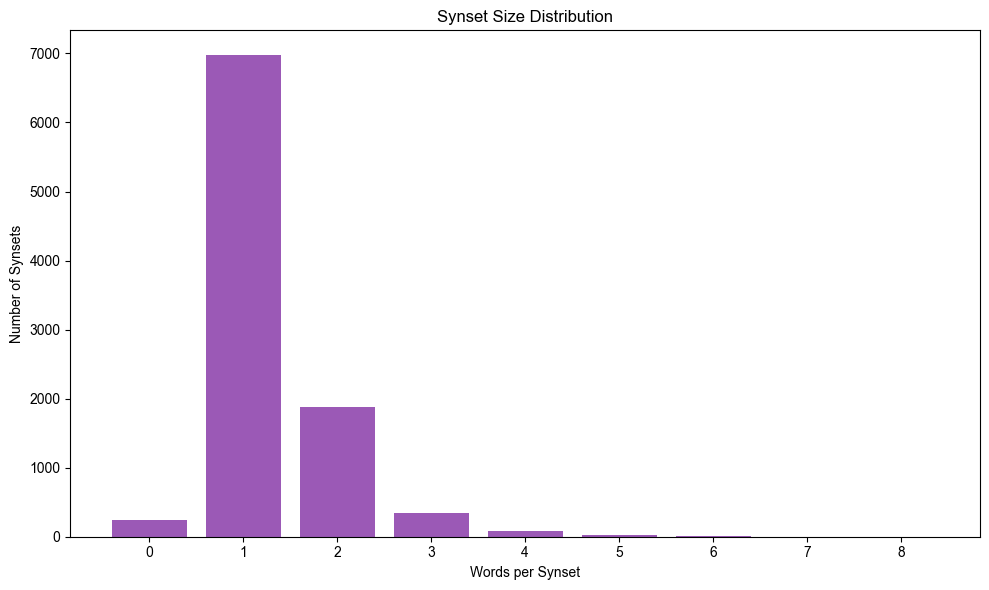

In [14]:
# Visualize synset size distribution
fig, ax = plt.subplots(figsize=(10, 6))

sizes = sorted(size_dist.keys())
counts = [size_dist[s] for s in sizes]

ax.bar(sizes, counts, color='#9b59b6')
ax.set_xlabel('Words per Synset')
ax.set_ylabel('Number of Synsets')
ax.set_title('Synset Size Distribution')
ax.set_xticks(sizes)

plt.tight_layout()
plt.show()

---
## Section 3: Structural Quality (Taxonomy Analysis)

In [15]:
print("=" * 70)
print("SECTION 3: STRUCTURAL QUALITY (Taxonomy Analysis)")
print("=" * 70)

# Count relations
hyper_count = 0
hypo_count = 0
with_hypernym = 0
with_hyponym = 0
orphan_synsets = []
root_synsets = []
leaf_synsets = []

for ss in awn3_synsets:
    hypernyms = ss.hypernyms()
    hyponyms = ss.hyponyms()
    hyper_count += len(hypernyms)
    hypo_count += len(hyponyms)
    
    if hypernyms:
        with_hypernym += 1
    if hyponyms:
        with_hyponym += 1
    
    if not hypernyms and not hyponyms:
        orphan_synsets.append(ss)
    elif not hypernyms and hyponyms:
        root_synsets.append(ss)
    elif hypernyms and not hyponyms:
        leaf_synsets.append(ss)

print(f"\nRelation Statistics:")
print("-" * 60)
print(f"{'Total hypernym relations':<40} {hyper_count:>15,}")
print(f"{'Total hyponym relations':<40} {hypo_count:>15,}")
print(f"{'Synsets with hypernym':<40} {with_hypernym:>15,} ({with_hypernym/len(awn3_synsets)*100:.1f}%)")
print(f"{'Synsets with hyponym':<40} {with_hyponym:>15,} ({with_hyponym/len(awn3_synsets)*100:.1f}%)")
print(f"{'Orphan synsets (no relations)':<40} {len(orphan_synsets):>15,} ({len(orphan_synsets)/len(awn3_synsets)*100:.1f}%)")
print(f"{'Root synsets (no hypernym, has hyponym)':<40} {len(root_synsets):>15,}")
print(f"{'Leaf synsets (has hypernym, no hyponym)':<40} {len(leaf_synsets):>15,}")

SECTION 3: STRUCTURAL QUALITY (Taxonomy Analysis)

Relation Statistics:
------------------------------------------------------------
Total hypernym relations                           8,904
Total hyponym relations                            8,904
Synsets with hypernym                              8,696 (90.9%)
Synsets with hyponym                               3,468 (36.2%)
Orphan synsets (no relations)                        752 (7.9%)
Root synsets (no hypernym, has hyponym)              119
Leaf synsets (has hypernym, no hyponym)            5,347


In [16]:
# Taxonomy depth analysis
def get_depth(ss, visited=None):
    """Get depth of synset in taxonomy (distance to root)."""
    if visited is None:
        visited = set()
    if ss.id in visited:
        return 0  # Cycle detected
    visited.add(ss.id)
    hypernyms = ss.hypernyms()
    if not hypernyms:
        return 0
    return 1 + max(get_depth(h, visited.copy()) for h in hypernyms)

print("\nCalculating taxonomy depths (sampling nouns)...")

# Calculate depths for noun synsets (sample for speed)
noun_synsets = [ss for ss in awn3_synsets if ss.pos == 'n']
sample_size = min(2000, len(noun_synsets))
noun_depths = [get_depth(ss) for ss in noun_synsets[:sample_size]]
depth_dist = Counter(noun_depths)

print(f"\nDepth Distribution (Nouns, sample of {sample_size}):")
print(f"{'Depth':<15} {'Count':>15} {'Percentage':>15}")
for depth in sorted(depth_dist.keys()):
    count = depth_dist[depth]
    pct = count / len(noun_depths) * 100
    print(f"{depth:<15} {count:>15,} {pct:>14.1f}%")

avg_depth = sum(noun_depths) / len(noun_depths) if noun_depths else 0
max_depth = max(noun_depths) if noun_depths else 0
print(f"\n{'Average noun depth':<40} {avg_depth:>15.2f}")
print(f"{'Maximum noun depth':<40} {max_depth:>15}")


Calculating taxonomy depths (sampling nouns)...

Depth Distribution (Nouns, sample of 2000):
Depth                     Count      Percentage
0                            32            1.6%
1                            17            0.9%
2                            25            1.2%
3                            54            2.7%
4                           174            8.7%
5                           346           17.3%
6                           391           19.6%
7                           380           19.0%
8                           292           14.6%
9                           146            7.3%
10                           80            4.0%
11                           32            1.6%
12                           17            0.9%
13                            9            0.4%
14                            5            0.2%

Average noun depth                                  6.43
Maximum noun depth                                    14


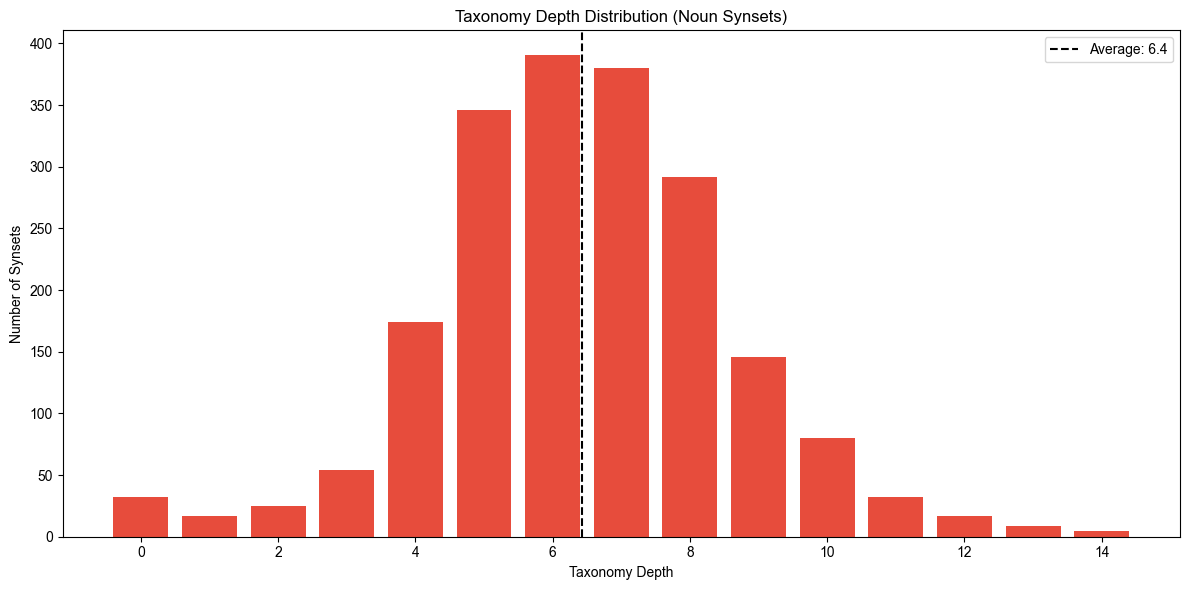

In [17]:
# Visualize taxonomy depth
fig, ax = plt.subplots(figsize=(12, 6))

depths = sorted(depth_dist.keys())
counts = [depth_dist[d] for d in depths]

ax.bar(depths, counts, color='#e74c3c')
ax.axvline(x=avg_depth, color='black', linestyle='--', label=f'Average: {avg_depth:.1f}')
ax.set_xlabel('Taxonomy Depth')
ax.set_ylabel('Number of Synsets')
ax.set_title('Taxonomy Depth Distribution (Noun Synsets)')
ax.legend()

plt.tight_layout()
plt.show()

In [18]:
# Sample orphan synsets
print(f"\nSample Orphan Synsets (first 10):")
print("-" * 70)
for ss in orphan_synsets[:10]:
    words = [w.lemma() for w in ss.words()[:3]]
    defn = ss.definition()
    defn_preview = defn[:40] + "..." if defn and len(defn) > 40 else defn
    print(f"  {ss.id}: {words}")
    print(f"    Definition: {defn_preview}")


Sample Orphan Synsets (first 10):
----------------------------------------------------------------------
  awn3-00761047-n: ['حَسَد']
    Definition: الحقد والاستياء بسبب نجاح شخص أو تمتعه ب...
  awn3-00951435-n: ['تَطْبِيق']
    Definition: نقل شيء ما إلى التنفيذ بشكل عملي ، واستخ...
  awn3-00952059-n: ['تكنولوجيا']
    Definition: تطبيق العلم والهندسة لتطوير الآلات والإج...
  awn3-00952181-n: ['هَنْدَسَة الطَيَرَان']
    Definition: فرع من فروع الهندسة ، يهتم بتصميم وبناء ...
  awn3-00952328-n: ['هندسة السيارات']
    Definition: أحد فروع الهندسة الذي يهتم بتصنيع وتطوير...
  awn3-00952467-n: ['هَنْدَسَة كِيمْيَائِيَّة']
    Definition: علم يختص بتطبيق الكيمياء لتطوير العمليات...
  awn3-00952816-n: ['تَقْنِيَة الاِتّْصَالات']
    Definition: التقانة التي تهتم بتصميم وصيانة أنظمة ال...
  awn3-00953148-n: ['تَقْنِيَة الحَاسُوب']
    Definition: التقانة التي تهتم بتصميم وصيانة أجهزة ال...
  awn3-02414351-n: ['كَبْش']
    Definition: ثدييات مجترة يغطيها الصوف ذات قرون ولها ...
  awn3-0242

---
## Section 4: Relation Quality Analysis

In [19]:
print("=" * 70)
print("SECTION 4: RELATION QUALITY ANALYSIS")
print("=" * 70)

# Build ILI mappings
awn3_ili_to_synset = {ss.ili.id: ss for ss in awn3_synsets if ss.ili}
oewn_ili_to_synset = {ss.ili.id: ss for ss in oewn_synsets if ss.ili}

matched_ilis = set(awn3_ili_to_synset.keys()) & set(oewn_ili_to_synset.keys())
print(f"\nRelation Coverage Comparison with OEWN:")
print("-" * 60)
print(f"{'Matched synsets via ILI':<40} {len(matched_ilis):>15,}")

SECTION 4: RELATION QUALITY ANALYSIS

Relation Coverage Comparison with OEWN:
------------------------------------------------------------
Matched synsets via ILI                            9,539


In [20]:
# Sample relation comparison
print("\nAnalyzing hypernym inheritance quality...")

awn3_has_hyper_oewn_has = 0
awn3_missing_hyper = 0
awn3_hyper_matches_oewn = 0

sample_ilis = list(matched_ilis)[:2000]
for ili_id in sample_ilis:
    awn3_ss = awn3_ili_to_synset[ili_id]
    oewn_ss = oewn_ili_to_synset[ili_id]
    
    awn3_hypers = awn3_ss.hypernyms()
    oewn_hypers = oewn_ss.hypernyms()
    
    if oewn_hypers:
        if awn3_hypers:
            awn3_has_hyper_oewn_has += 1
            awn3_hyper_ilis = {h.ili.id for h in awn3_hypers if h.ili}
            oewn_hyper_ilis = {h.ili.id for h in oewn_hypers if h.ili}
            if awn3_hyper_ilis & oewn_hyper_ilis:
                awn3_hyper_matches_oewn += 1
        else:
            awn3_missing_hyper += 1

print(f"\nHypernym Inheritance Quality (sample of {len(sample_ilis)}):")
print("-" * 60)
print(f"{'OEWN synsets with hypernym in sample':<40} {awn3_has_hyper_oewn_has + awn3_missing_hyper:>15,}")
print(f"{'AWN3 inherited hypernym':<40} {awn3_has_hyper_oewn_has:>15,}")
print(f"{'AWN3 missing hypernym (target not in AWN3)':<40} {awn3_missing_hyper:>15,}")
print(f"{'AWN3 hypernym matches OEWN hypernym':<40} {awn3_hyper_matches_oewn:>15,}")


Analyzing hypernym inheritance quality...

Hypernym Inheritance Quality (sample of 2000):
------------------------------------------------------------
OEWN synsets with hypernym in sample               1,892
AWN3 inherited hypernym                            1,816
AWN3 missing hypernym (target not in AWN3)              76
AWN3 hypernym matches OEWN hypernym                1,816


In [21]:
# Relation density comparison
print(f"\nRelation Density Comparison:")
print("-" * 60)

awn3_total_relations = sum(len(ss.hypernyms()) + len(ss.hyponyms()) for ss in awn3_synsets)
awn3_density = awn3_total_relations / len(awn3_synsets) if awn3_synsets else 0

oewn_sample = oewn_synsets[:10000]
oewn_total_relations = sum(len(ss.hypernyms()) + len(ss.hyponyms()) for ss in oewn_sample)
oewn_density = oewn_total_relations / len(oewn_sample) if oewn_sample else 0

print(f"{'AWN3 avg relations per synset':<40} {awn3_density:>15.2f}")
print(f"{'OEWN avg relations per synset (sample)':<40} {oewn_density:>15.2f}")

print(f"\nRelation Types Available:")
print("-" * 60)
print("  Currently inherited: hypernym, hyponym")
print("  Not inherited: meronym, holonym, domain, similar, etc.")


Relation Density Comparison:
------------------------------------------------------------
AWN3 avg relations per synset                       1.86
OEWN avg relations per synset (sample)              1.06

Relation Types Available:
------------------------------------------------------------
  Currently inherited: hypernym, hyponym
  Not inherited: meronym, holonym, domain, similar, etc.


---
## Section 5: Definition & Example Quality

In [22]:
print("=" * 70)
print("SECTION 5: DEFINITION & EXAMPLE QUALITY")
print("=" * 70)

# Definition analysis
with_definition = 0
definition_lengths = []
empty_definitions = []
short_definitions = []

for ss in awn3_synsets:
    defn = ss.definition()
    if defn and defn.strip():
        with_definition += 1
        definition_lengths.append(len(defn))
        if len(defn) < 10:
            short_definitions.append((ss, defn))
    else:
        empty_definitions.append(ss)

print(f"\nDefinition Coverage:")
print("-" * 60)
print(f"{'Synsets with definition':<40} {with_definition:>15,} ({with_definition/len(awn3_synsets)*100:.1f}%)")
print(f"{'Synsets without definition':<40} {len(empty_definitions):>15,} ({len(empty_definitions)/len(awn3_synsets)*100:.1f}%)")
print(f"{'Short definitions (<10 chars)':<40} {len(short_definitions):>15,}")

SECTION 5: DEFINITION & EXAMPLE QUALITY

Definition Coverage:
------------------------------------------------------------
Synsets with definition                            9,315 (97.4%)
Synsets without definition                           252 (2.6%)
Short definitions (<10 chars)                         15


In [23]:
# Definition length statistics
if definition_lengths:
    print(f"\nDefinition Length Statistics:")
    print("-" * 60)
    print(f"{'Average length (chars)':<40} {statistics.mean(definition_lengths):>15.1f}")
    print(f"{'Median length (chars)':<40} {statistics.median(definition_lengths):>15.1f}")
    print(f"{'Min length (chars)':<40} {min(definition_lengths):>15}")
    print(f"{'Max length (chars)':<40} {max(definition_lengths):>15}")


Definition Length Statistics:
------------------------------------------------------------
Average length (chars)                              53.2
Median length (chars)                               46.0
Min length (chars)                                     4
Max length (chars)                                   265


In [24]:
# Example analysis
with_example = 0
example_lengths = []
empty_examples = []

for ss in awn3_synsets:
    examples = ss.examples()
    if examples:
        with_example += 1
        for ex in examples:
            example_lengths.append(len(ex))
    else:
        empty_examples.append(ss)

print(f"\nExample Coverage:")
print("-" * 60)
print(f"{'Synsets with examples':<40} {with_example:>15,} ({with_example/len(awn3_synsets)*100:.1f}%)")
print(f"{'Synsets without examples':<40} {len(empty_examples):>15,} ({len(empty_examples)/len(awn3_synsets)*100:.1f}%)")

if example_lengths:
    print(f"\nExample Length Statistics:")
    print("-" * 60)
    print(f"{'Average length (chars)':<40} {statistics.mean(example_lengths):>15.1f}")
    print(f"{'Median length (chars)':<40} {statistics.median(example_lengths):>15.1f}")
    print(f"{'Min length (chars)':<40} {min(example_lengths):>15}")
    print(f"{'Max length (chars)':<40} {max(example_lengths):>15}")


Example Coverage:
------------------------------------------------------------
Synsets with examples                              9,254 (96.7%)
Synsets without examples                             313 (3.3%)

Example Length Statistics:
------------------------------------------------------------
Average length (chars)                              52.2
Median length (chars)                               48.0
Min length (chars)                                     8
Max length (chars)                                   225


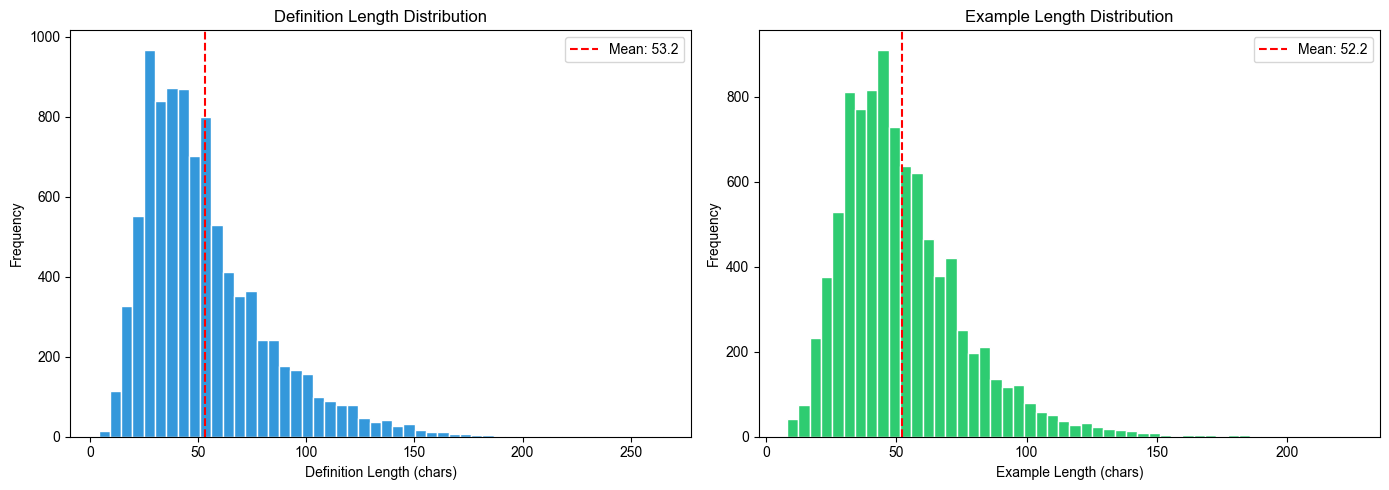

In [25]:
# Visualize definition and example length distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Definition lengths
axes[0].hist(definition_lengths, bins=50, color='#3498db', edgecolor='white')
axes[0].axvline(x=statistics.mean(definition_lengths), color='red', linestyle='--', label=f'Mean: {statistics.mean(definition_lengths):.1f}')
axes[0].set_xlabel('Definition Length (chars)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Definition Length Distribution')
axes[0].legend()

# Example lengths
axes[1].hist(example_lengths, bins=50, color='#2ecc71', edgecolor='white')
axes[1].axvline(x=statistics.mean(example_lengths), color='red', linestyle='--', label=f'Mean: {statistics.mean(example_lengths):.1f}')
axes[1].set_xlabel('Example Length (chars)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Example Length Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

In [26]:
# Arabic text quality checks
print(f"\nArabic Text Quality Checks:")
print("-" * 60)

mixed_script_count = 0
has_diacritics_count = 0
diacritic_pattern = re.compile(r'[\u064B-\u065F\u0670]')  # Arabic diacritical marks

for ss in awn3_synsets:
    defn = ss.definition()
    if defn:
        # Check for Latin characters mixed with Arabic
        if re.search(r'[a-zA-Z]', defn) and re.search(r'[\u0600-\u06FF]', defn):
            mixed_script_count += 1
        # Check for diacritics
        if diacritic_pattern.search(defn):
            has_diacritics_count += 1

print(f"{'Definitions with mixed Arabic/Latin':<40} {mixed_script_count:>15,}")
print(f"{'Definitions with diacritics (tashkeel)':<40} {has_diacritics_count:>15,} ({has_diacritics_count/with_definition*100:.1f}%)")


Arabic Text Quality Checks:
------------------------------------------------------------
Definitions with mixed Arabic/Latin                    9
Definitions with diacritics (tashkeel)             2,227 (23.9%)


In [27]:
# Sample definitions and examples
print(f"\nSample Definitions:")
print("-" * 70)
for ss in awn3_synsets[:5]:
    words = [w.lemma() for w in ss.words()[:2]]
    defn = ss.definition()
    defn_preview = defn[:60] + "..." if defn and len(defn) > 60 else defn
    print(f"  {words}: {defn_preview}")

print(f"\nSample Examples:")
print("-" * 70)
for ss in awn3_synsets[:5]:
    words = [w.lemma() for w in ss.words()[:2]]
    examples = ss.examples()
    if examples:
        ex_preview = examples[0][:60] + "..." if len(examples[0]) > 60 else examples[0]
        print(f"  {words}: {ex_preview}")


Sample Definitions:
----------------------------------------------------------------------
  ['كيان']: بنية ذات وجود خاص بحد ذاته ( سواء كان حياً أم غير حي )
  ['اِسْم']: وحدة لغوية نطلقها على شخص أو شيء ليعرف به
  ['وَصْف شَفَهِيّ', 'وَصْف لَفْظِيّ']: عبارة من مجموعة كلمات مركبة لفظياً تعبر عن شيء ما
  ['مِثَال']: معلومة تمثل نموذجاً لشيء ما
  ['جِزْء', 'قِسْم']: شيء ضمن شيء يعتبر أنه يحتويه أو ذو صلة به

Sample Examples:
----------------------------------------------------------------------
  ['كيان']: الكيان التعليمي في بلادنا متطور،
  ['اِسْم']: سامر هو الاسم الذي يطلق على ذلك الشخص. ما اسمك؟
  ['وَصْف شَفَهِيّ', 'وَصْف لَفْظِيّ']: قلب الظلام وصف شفهي يعبر عن الظلام الدامس. لسان حال المرء، ه...
  ['مِثَال']: الخوخ، الدراق، البطيخ والكرز هي أمثلة عن فواكه الصيف
  ['جِزْء', 'قِسْم']: الأجزاء الرئيسية في جسم الإنسان هي الرأس والجذع والأطراف ، أ...


---
## Section 6: ILI Alignment Quality

In [28]:
print("=" * 70)
print("SECTION 6: ILI ALIGNMENT QUALITY")
print("=" * 70)

with_ili = [ss for ss in awn3_synsets if ss.ili]
without_ili = [ss for ss in awn3_synsets if not ss.ili]

print(f"\nILI Coverage:")
print("-" * 60)
print(f"{'Synsets with ILI':<40} {len(with_ili):>15,} ({len(with_ili)/len(awn3_synsets)*100:.1f}%)")
print(f"{'Synsets without ILI':<40} {len(without_ili):>15,} ({len(without_ili)/len(awn3_synsets)*100:.1f}%)")

SECTION 6: ILI ALIGNMENT QUALITY

ILI Coverage:
------------------------------------------------------------
Synsets with ILI                                   9,539 (99.7%)
Synsets without ILI                                   28 (0.3%)


In [29]:
# ILI by POS
print(f"\nILI Coverage by POS:")
print("-" * 60)
for pos in ['n', 'v', 'a', 'r']:
    pos_synsets = [ss for ss in awn3_synsets if ss.pos == pos]
    pos_with_ili = [ss for ss in pos_synsets if ss.ili]
    pct = len(pos_with_ili) / len(pos_synsets) * 100 if pos_synsets else 0
    print(f"  {pos_names[pos]:<20} {len(pos_with_ili):>8,} / {len(pos_synsets):>8,} ({pct:.1f}%)")


ILI Coverage by POS:
------------------------------------------------------------
  Nouns                   6,503 /    6,511 (99.9%)
  Verbs                   2,483 /    2,503 (99.2%)
  Adjectives                446 /      446 (100.0%)
  Adverbs                   107 /      107 (100.0%)


In [30]:
# Cross-lingual alignment test
print(f"\nCross-Lingual Alignment Test:")
print("-" * 60)
print("Testing Arabic → English concept mapping via ILI...")

test_words = ['كلب', 'قطّ', 'سيارة', 'كتاب', 'طعام', 'ماء', 'شمس', 'قمر', 'بيت', 'شجرة']
print(f"\nSample Arabic → English Mappings:")
for ar_word in test_words:
    ar_synsets_list = awn3.synsets(ar_word)
    if ar_synsets_list:
        ar_ss = ar_synsets_list[0]
        if ar_ss.ili:
            en_ss_list = oewn.synsets(ili=ar_ss.ili)
            if en_ss_list:
                en_ss = en_ss_list[0]
                en_words = [w.lemma() for w in en_ss.words()[:3]]
                print(f"  {ar_word:<15} → {en_words}")
            else:
                print(f"  {ar_word:<15} → [No English match]")
        else:
            print(f"  {ar_word:<15} → [No ILI]")
    else:
        print(f"  {ar_word:<15} → [Not found in AWN3]")


Cross-Lingual Alignment Test:
------------------------------------------------------------
Testing Arabic → English concept mapping via ILI...

Sample Arabic → English Mappings:
  كلب             → ['dog', 'domestic dog', 'Canis familiaris']
  قطّ             → [Not found in AWN3]
  سيارة           → ['car', 'auto', 'automobile']
  كتاب            → ['book']
  طعام            → ['food', 'nutrient']
  ماء             → ['water system', 'water supply', 'water']
  شمس             → ['sun', 'Sun']
  قمر             → ['moon']
  بيت             → ['dwelling', 'home', 'domicile']
  شجرة            → ['tree']


In [31]:
# Synsets without ILI - sample
print(f"\nSample Synsets WITHOUT ILI (first 10):")
print("-" * 70)
for ss in without_ili[:10]:
    words = [w.lemma() for w in ss.words()[:3]]
    defn = ss.definition()
    defn_preview = defn[:40] + "..." if defn and len(defn) > 40 else defn
    print(f"  {ss.id}: {words}")
    print(f"    Definition: {defn_preview}")


Sample Synsets WITHOUT ILI (first 10):
----------------------------------------------------------------------
  awn3-00951435-n: ['تَطْبِيق']
    Definition: نقل شيء ما إلى التنفيذ بشكل عملي ، واستخ...
  awn3-03739038-n: ['واسِطَة', 'وَسِيلَة']
    Definition: أداة لإنجاز شيء ما بواسطتها
  awn3-05694760-n: ['صُعُوبَة']
    Definition: عامل يسبب مشكلة في تحقيق نتيجة إيجابية أ...
  awn3-06631572-n: ['اِسْتِعْرَاض', 'عَرْض']
    Definition: حدث اجتماعي يتضمن أداء شعبياً لمختلف الف...
  awn3-00811359-n: ['هِنْدُوسِيَّة']
    Definition: الديانة السائدة في الهند وتتميز بعبادة ا...
  awn3-08269132-n: ['لِقاء اِجْتِماعِيّ']
    Definition: تجمع لغرض تعزيز الزمالة بين الأشخاص
  awn3-08517241-n: ['أعْمَاق', 'عُمْق']
    Definition: أبعد وأعمق منطقة
  awn3-14431490-n: ['صُعُوبَة']
    Definition: حالة من الضيق والحرج والعناء في أمر يحتا...
  awn3-00065266-v: []
    Definition: يكون بصحة جيدة ولا يشتكي من الأمراض
  awn3-00078154-v: ['عَانَى']
    Definition: يشعر بأنه في حال سيئة وغير مرتاح


---
## Section 7: Comparison with OMW-ARB Baseline

In [32]:
print("=" * 70)
print("SECTION 7: COMPARISON WITH OMW-ARB BASELINE")
print("=" * 70)

if not HAS_OMW_ARB:
    print("\n⚠ OMW-ARB not available for comparison.")
    print("To download: wn.download('omw-arb:1.4')")
else:
    print(f"\nSide-by-Side Comparison:")
    print("-" * 70)
    print(f"{'Metric':<40} {'AWN3':>15} {'OMW-ARB':>15}")
    print("-" * 70)
    
    # Basic counts
    print(f"{'Synsets':<40} {len(awn3_synsets):>15,} {len(omw_synsets):>15,}")
    print(f"{'Words':<40} {len(awn3_words):>15,} {len(omw_words):>15,}")
    print(f"{'Senses':<40} {len(awn3_senses):>15,} {len(omw_senses):>15,}")
    
    # ILI coverage
    awn3_with_ili_count = sum(1 for ss in awn3_synsets if ss.ili)
    omw_with_ili_count = sum(1 for ss in omw_synsets if ss.ili)
    print(f"{'Synsets with ILI':<40} {awn3_with_ili_count:>15,} {omw_with_ili_count:>15,}")
    
    # Relations
    awn3_hyper = sum(len(ss.hypernyms()) for ss in awn3_synsets)
    omw_hyper = sum(len(ss.hypernyms()) for ss in omw_synsets)
    awn3_hypo = sum(len(ss.hyponyms()) for ss in awn3_synsets)
    omw_hypo = sum(len(ss.hyponyms()) for ss in omw_synsets)
    print(f"{'Hypernym relations':<40} {awn3_hyper:>15,} {omw_hyper:>15,}")
    print(f"{'Hyponym relations':<40} {awn3_hypo:>15,} {omw_hypo:>15,}")
    
    # Definitions
    awn3_with_def = sum(1 for ss in awn3_synsets if ss.definition())
    omw_with_def = sum(1 for ss in omw_synsets if ss.definition())
    print(f"{'Synsets with Arabic definition':<40} {awn3_with_def:>15,} {omw_with_def:>15,}")
    
    # Examples
    awn3_with_ex = sum(1 for ss in awn3_synsets if ss.examples())
    omw_with_ex = sum(1 for ss in omw_synsets if ss.examples())
    print(f"{'Synsets with Arabic examples':<40} {awn3_with_ex:>15,} {omw_with_ex:>15,}")

SECTION 7: COMPARISON WITH OMW-ARB BASELINE

Side-by-Side Comparison:
----------------------------------------------------------------------
Metric                                              AWN3         OMW-ARB
----------------------------------------------------------------------
Synsets                                            9,567           9,916
Words                                             12,310          18,003
Senses                                            12,310          37,342
Synsets with ILI                                   9,539           9,916
Hypernym relations                                 8,904           9,272
Hyponym relations                                  8,904          57,352
Synsets with Arabic definition                     9,315               0
Synsets with Arabic examples                       9,254               0


In [33]:
if HAS_OMW_ARB:
    # Percentage improvements
    print(f"\nKey Quality Improvements (AWN3 vs OMW-ARB):")
    print("-" * 70)
    
    def_pct_awn3 = awn3_with_def / len(awn3_synsets) * 100
    def_pct_omw = omw_with_def / len(omw_synsets) * 100
    def_improve = def_pct_awn3 - def_pct_omw
    
    ex_pct_awn3 = awn3_with_ex / len(awn3_synsets) * 100
    ex_pct_omw = omw_with_ex / len(omw_synsets) * 100
    ex_improve = ex_pct_awn3 - ex_pct_omw
    
    print(f"{'Arabic Definition Coverage':<40} {def_pct_awn3:>6.1f}% vs {def_pct_omw:>6.1f}% ({def_improve:+.1f}%)")
    print(f"{'Arabic Example Coverage':<40} {ex_pct_awn3:>6.1f}% vs {ex_pct_omw:>6.1f}% ({ex_improve:+.1f}%)")


Key Quality Improvements (AWN3 vs OMW-ARB):
----------------------------------------------------------------------
Arabic Definition Coverage                 97.4% vs    0.0% (+97.4%)
Arabic Example Coverage                    96.7% vs    0.0% (+96.7%)


In [34]:
if HAS_OMW_ARB:
    # Overlap analysis via ILI
    awn3_ilis_set = {ss.ili.id for ss in awn3_synsets if ss.ili}
    omw_ilis_set = {ss.ili.id for ss in omw_synsets if ss.ili}
    common = awn3_ilis_set & omw_ilis_set
    only_awn3 = awn3_ilis_set - omw_ilis_set
    only_omw = omw_ilis_set - awn3_ilis_set
    
    print(f"\nILI-based Overlap Analysis:")
    print("-" * 70)
    print(f"{'Concepts in both AWN3 and OMW-ARB':<40} {len(common):>15,}")
    print(f"{'Concepts only in AWN3':<40} {len(only_awn3):>15,}")
    print(f"{'Concepts only in OMW-ARB':<40} {len(only_omw):>15,}")


ILI-based Overlap Analysis:
----------------------------------------------------------------------
Concepts in both AWN3 and OMW-ARB                  9,296
Concepts only in AWN3                                243
Concepts only in OMW-ARB                             620


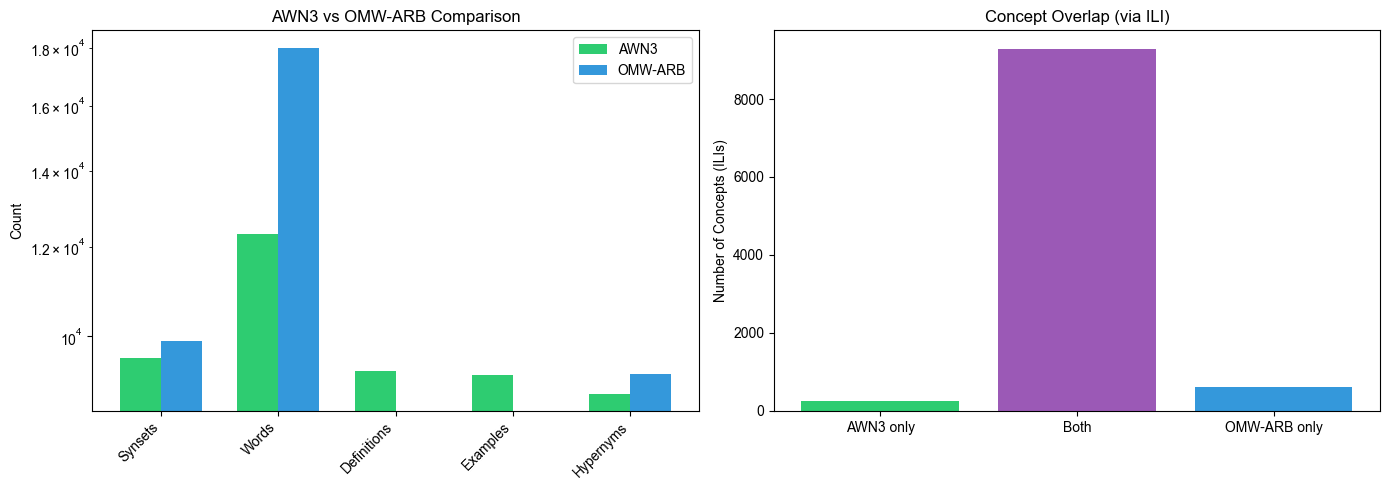

In [35]:
if HAS_OMW_ARB:
    # Visualize comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart comparison
    metrics = ['Synsets', 'Words', 'Definitions', 'Examples', 'Hypernyms']
    awn3_values = [len(awn3_synsets), len(awn3_words), awn3_with_def, awn3_with_ex, awn3_hyper]
    omw_values = [len(omw_synsets), len(omw_words), omw_with_def, omw_with_ex, omw_hyper]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    axes[0].bar(x - width/2, awn3_values, width, label='AWN3', color='#2ecc71')
    axes[0].bar(x + width/2, omw_values, width, label='OMW-ARB', color='#3498db')
    axes[0].set_ylabel('Count')
    axes[0].set_title('AWN3 vs OMW-ARB Comparison')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metrics, rotation=45, ha='right')
    axes[0].legend()
    axes[0].set_yscale('log')
    
    # Venn-like overlap
    overlap_data = [len(only_awn3), len(common), len(only_omw)]
    overlap_labels = ['AWN3 only', 'Both', 'OMW-ARB only']
    colors = ['#2ecc71', '#9b59b6', '#3498db']
    axes[1].bar(overlap_labels, overlap_data, color=colors)
    axes[1].set_ylabel('Number of Concepts (ILIs)')
    axes[1].set_title('Concept Overlap (via ILI)')
    
    plt.tight_layout()
    plt.show()

---
## Section 8: Summary Report

In [36]:
print("=" * 80)
print("SECTION 8: COMPREHENSIVE QUALITY SUMMARY REPORT")
print("=" * 80)

# Calculate all metrics
def_coverage = with_definition / len(awn3_synsets) * 100
ex_coverage = with_example / len(awn3_synsets) * 100
ili_coverage = len(with_ili) / len(awn3_synsets) * 100
taxonomy_coverage = with_hypernym / len(awn3_synsets) * 100
oewn_coverage = len(awn3_synsets) / len(oewn_synsets) * 100

print(f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    AWN3 (Arabic WordNet V3) QUALITY REPORT                    ║
╚══════════════════════════════════════════════════════════════════════════════╝

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 OVERALL SCORES

    ┌─────────────────────────────┬───────────┬───────────┐
    │ Metric                      │ Score     │ Grade     │
    ├─────────────────────────────┼───────────┼───────────┤
    │ Arabic Definition Coverage  │   {def_coverage:5.1f}%  │    {'★★★★★' if def_coverage > 90 else '★★★★☆' if def_coverage > 75 else '★★★☆☆'}  │
    │ Arabic Example Coverage     │   {ex_coverage:5.1f}%  │    {'★★★★★' if ex_coverage > 90 else '★★★★☆' if ex_coverage > 75 else '★★★☆☆'}  │
    │ ILI Alignment               │   {ili_coverage:5.1f}%  │    {'★★★★★' if ili_coverage > 90 else '★★★★☆' if ili_coverage > 75 else '★★★☆☆'}  │
    │ Taxonomy Coverage           │   {taxonomy_coverage:5.1f}%  │    {'★★★★★' if taxonomy_coverage > 90 else '★★★★☆' if taxonomy_coverage > 75 else '★★★☆☆'}  │
    │ OEWN Coverage               │    {oewn_coverage:5.1f}%  │    {'★★★★★' if oewn_coverage > 20 else '★★★☆☆' if oewn_coverage > 10 else '★★☆☆☆'}  │
    └─────────────────────────────┴───────────┴───────────┘

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📈 BASIC STATISTICS

    Synsets:          {len(awn3_synsets):>10,}
    Words:            {len(awn3_words):>10,}
    Senses:           {len(awn3_senses):>10,}
    ILI-linked:       {len(with_ili):>10,} ({ili_coverage:.1f}%)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔗 RELATION STATISTICS

    Hypernym relations:   {hyper_count:>10,}
    Hyponym relations:    {hypo_count:>10,}
    
    Synsets with hypernym: {with_hypernym:>8,} ({taxonomy_coverage:.1f}%)
    Orphan synsets:        {len(orphan_synsets):>8,} ({len(orphan_synsets)/len(awn3_synsets)*100:.1f}%)
    
    Average taxonomy depth: {avg_depth:.2f} (max: {max_depth})

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📝 CONTENT QUALITY

    With Arabic definition:  {with_definition:>8,} ({def_coverage:.1f}%)
    With Arabic examples:    {with_example:>8,} ({ex_coverage:.1f}%)
    With diacritics:         {has_diacritics_count:>8,} ({has_diacritics_count/with_definition*100:.1f}%)
    
    Lexical gaps:            {len(empty_synsets):>8,} ({len(empty_synsets)/len(awn3_synsets)*100:.1f}%)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⚠️  ISSUES IDENTIFIED

    HIGH PRIORITY:
    1. Orphan synsets ({len(orphan_synsets)}) - No relations, isolated in taxonomy
    2. Missing relations - Only hypernym/hyponym inherited
    3. Empty synsets ({len(empty_synsets)}) - Lexical gaps with no Arabic words
    
    MEDIUM PRIORITY:
    4. Low polysemy ({polysemous/len(awn3_words)*100:.0f}%) - Each word in only 1 synset
    5. {len(without_ili)} synsets without ILI
    6. {len(empty_definitions)} synsets without definitions

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ RECOMMENDATIONS

    IMMEDIATE:
    1. Inherit additional relation types from OEWN
    2. Review and connect orphan synsets
    3. Fill lexical gaps where possible
    
    FUTURE:
    4. Consider merging with OMW-ARB for additional lemmas
    5. Add polysemy - link words to multiple synsets
    6. Expand coverage toward OEWN's {len(oewn_synsets):,} synsets

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")

SECTION 8: COMPREHENSIVE QUALITY SUMMARY REPORT

╔══════════════════════════════════════════════════════════════════════════════╗
║                    AWN3 (Arabic WordNet V3) QUALITY REPORT                    ║
╚══════════════════════════════════════════════════════════════════════════════╝

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 OVERALL SCORES

    ┌─────────────────────────────┬───────────┬───────────┐
    │ Metric                      │ Score     │ Grade     │
    ├─────────────────────────────┼───────────┼───────────┤
    │ Arabic Definition Coverage  │    97.4%  │    ★★★★★  │
    │ Arabic Example Coverage     │    96.7%  │    ★★★★★  │
    │ ILI Alignment               │    99.7%  │    ★★★★★  │
    │ Taxonomy Coverage           │    90.9%  │    ★★★★★  │
    │ OEWN Coverage               │      7.9%  │    ★★☆☆☆  │
    └─────────────────────────────┴───────────┴───────────┘

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [38]:
# Create summary DataFrame for export
summary_data = {
    'Metric': [
        'Total Synsets',
        'Total Words',
        'Total Senses',
        'Synsets with ILI',
        'ILI Coverage %',
        'Synsets with Definition',
        'Definition Coverage %',
        'Synsets with Examples',
        'Example Coverage %',
        'Hypernym Relations',
        'Hyponym Relations',
        'Synsets with Hypernym',
        'Taxonomy Coverage %',
        'Orphan Synsets',
        'Orphan %',
        'Lexical Gaps',
        'Average Taxonomy Depth',
        'Max Taxonomy Depth',
        'OEWN Coverage %'
    ],
    'Value': [
        len(awn3_synsets),
        len(awn3_words),
        len(awn3_senses),
        len(with_ili),
        round(ili_coverage, 1),
        with_definition,
        round(def_coverage, 1),
        with_example,
        round(ex_coverage, 1),
        hyper_count,
        hypo_count,
        with_hypernym,
        round(taxonomy_coverage, 1),
        len(orphan_synsets),
        round(len(orphan_synsets)/len(awn3_synsets)*100, 1),
        len(empty_synsets),
        round(avg_depth, 2),
        max_depth,
        round(oewn_coverage, 1)
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\nSummary DataFrame:")
print(summary_df.to_string(index=False))


Summary DataFrame:
                 Metric    Value
          Total Synsets  9567.00
            Total Words 12310.00
           Total Senses 12310.00
       Synsets with ILI  9539.00
         ILI Coverage %    99.70
Synsets with Definition  9315.00
  Definition Coverage %    97.40
  Synsets with Examples  9254.00
     Example Coverage %    96.70
     Hypernym Relations  8904.00
      Hyponym Relations  8904.00
  Synsets with Hypernym  8696.00
    Taxonomy Coverage %    90.90
         Orphan Synsets   752.00
               Orphan %     7.90
           Lexical Gaps   236.00
 Average Taxonomy Depth     6.43
     Max Taxonomy Depth    14.00
        OEWN Coverage %     7.90


In [39]:
# Export summary to CSV
export_path = 'exports/awn3_quality_summary.csv'
import os
os.makedirs('exports', exist_ok=True)
summary_df.to_csv(export_path, index=False)
print(f"\n✓ Summary exported to: {export_path}")


✓ Summary exported to: exports/awn3_quality_summary.csv


---
## Conclusion

This notebook provides a comprehensive quality assessment of the AWN3 Arabic WordNet. Key findings:

**Strengths:**
- Excellent Arabic content quality (97%+ definitions and examples)
- Strong ILI alignment (99.7% cross-lingual linkage)
- Well-structured taxonomy (avg depth 6.4, max 14)

**Areas for Improvement:**
- 752 orphan synsets need relations
- Only hypernym/hyponym relations (missing meronym, domain, etc.)
- 236 lexical gaps (empty synsets)
- 0% polysemy (each word in only 1 synset)

**Recommendation:** AWN3 provides excellent Arabic content quality and should be used as the primary Arabic WordNet. Consider merging with OMW-ARB to get additional lemmas and relations.